In [1]:
import torch

from model import GradKNN
from configs.config import config

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from utils.other import GradKNNDataloader

data_loader = GradKNNDataloader(num_tasks=6, dataset_name="imagenet-r", load_covariances=True, load_prototypes=False)
model = GradKNN(config, device=device)

for i in range(6):
    X_train, y_train, X_test, y_test, covariances, prototypes = data_loader.get_data(i)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    acc = (torch.sum((y_test.flatten().to(device) == predictions).int()) / X_test.shape[0] * 100).item()
    print(f"Accuracy: {acc} MY\n")

Accuracy: 81.71334075927734 MY

Accuracy: 77.06422424316406 MY

Accuracy: 72.29411315917969 MY

Accuracy: 70.6161117553711 MY

Accuracy: 68.5843734741211 MY

Accuracy: 65.38146209716797 MY



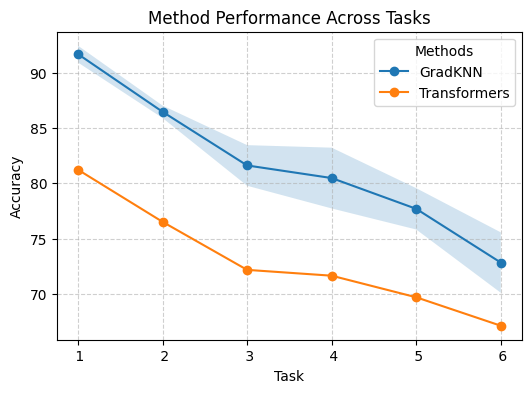

In [1]:
import pandas as pd
from utils.draw_plot import plot_method_scores

plot_method_scores(pd.read_csv("./data/example_chart_data.csv"))